<a href="https://colab.research.google.com/github/harivarshith/NLP-Assignments-1351/blob/main/10.10.25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


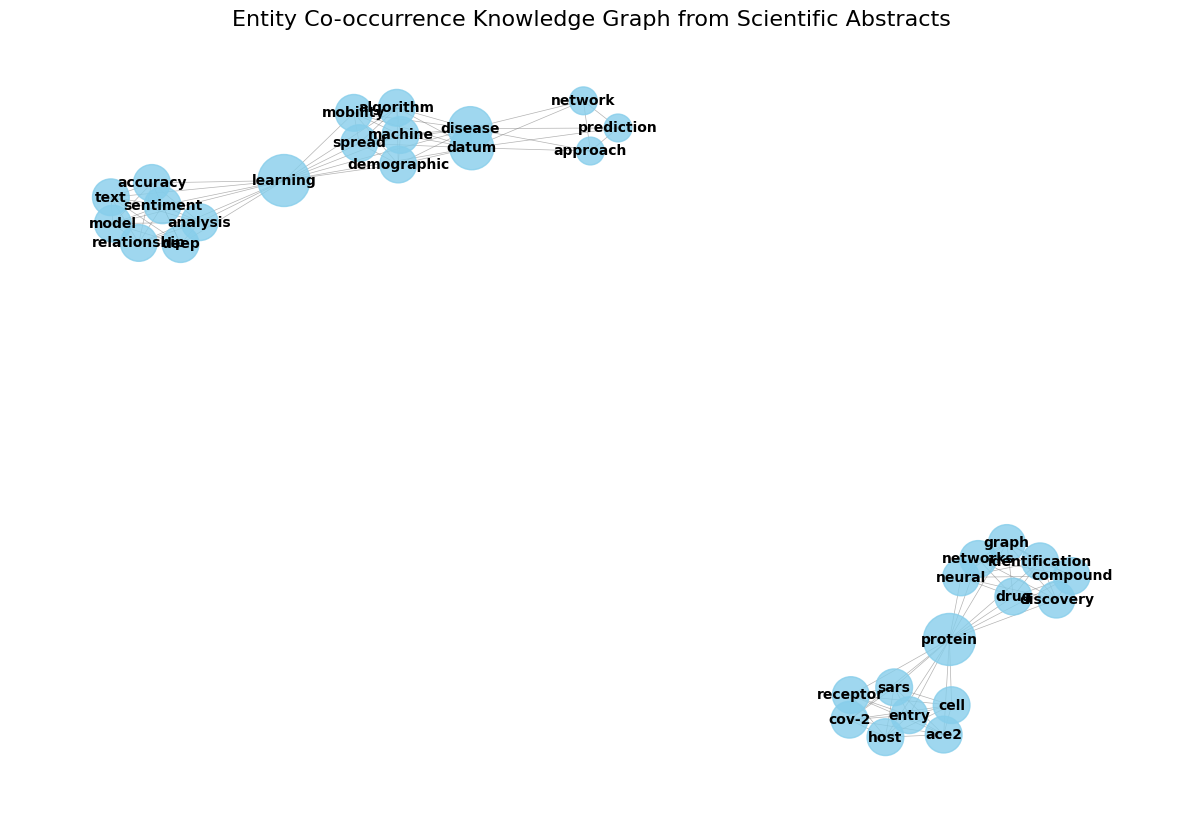


## Top 10 Most Central Nodes (Keywords) by Eigenvector Centrality 🔑
|             |   Degree |   Betweenness |   Eigenvector |
|:------------|---------:|--------------:|--------------:|
| learning    |   0.4375 |        0.1411 |        0.4191 |
| datum       |   0.3125 |        0.0393 |        0.2812 |
| disease     |   0.3125 |        0.0393 |        0.2812 |
| machine     |   0.2188 |        0.0000 |        0.2494 |
| mobility    |   0.2188 |        0.0000 |        0.2494 |
| algorithm   |   0.2188 |        0.0000 |        0.2494 |
| demographic |   0.2188 |        0.0000 |        0.2494 |
| spread      |   0.2188 |        0.0000 |        0.2494 |
| accuracy    |   0.2188 |        0.0000 |        0.2165 |
| analysis    |   0.2188 |        0.0000 |        0.2165 |

## Analysis: Discovering Emerging Topics 💡
This co-occurrence graph helps researchers discover emerging topics by highlighting highly connected and influential entities.
1. **Core Topics (High Degree/Eigenvector):** Entiti

In [1]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import string
import nltk
nltk.download('stopwords')

# --- 1. Dataset Simulation ---
# Simulate a dataset of scientific abstracts
data = {
    'abstract': [
        'Deep Learning models significantly improve the accuracy of sentiment analysis by capturing complex contextual relationships in text.',
        'The spike protein of SARS-CoV-2 interacts with the human ACE2 receptor, initiating viral entry into host cells.',
        'Machine Learning algorithms predict the spread of infectious diseases using mobility data and patient demographics.',
        'Graph Neural Networks are used for drug discovery, accelerating the identification of novel compounds targeting specific proteins.',
        'A novel approach uses recurrent neural networks to process temporal physiological data for early disease prediction.'
    ]
}
df = pd.DataFrame(data)

# --- 2. Preprocessing & Initialization ---

nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")
STOP_WORDS = set(stopwords.words('english'))
PUNCTUATION = string.punctuation

def preprocess_text(text):
    doc = nlp(text)

    clean_tokens = []
    for token in doc:
        # Lowercase and lemmatize
        lemma = token.lemma_.lower()

        # Check for stop words, punctuation, and non-alphanumeric tokens
        if lemma not in STOP_WORDS and lemma not in PUNCTUATION and lemma.isalpha():
            clean_tokens.append(lemma)

    return " ".join(clean_tokens)

df['clean_abstract'] = df['abstract'].apply(preprocess_text)


def extract_entities_and_relations(text):
    doc = nlp(text)
    entity_tokens = []
    for sent in doc.sents:
        sent_entities = []
        for token in sent:
            if token.pos_ in ("NOUN", "PROPN"):
                sent_entities.append(token.lemma_.lower())
        entity_tokens.append(sent_entities)

    return entity_tokens

df['entities_per_sentence'] = df['abstract'].apply(extract_entities_and_relations)


G = nx.Graph()

for entity_list_per_sent in df['entities_per_sentence']:
    for sent_entities in entity_list_per_sent:
        unique_entities = list(set(sent_entities))

        if len(unique_entities) > 1:
            for i in range(len(unique_entities)):
                for j in range(i + 1, len(unique_entities)):
                    entity1 = unique_entities[i]
                    entity2 = unique_entities[j]

                    if G.has_edge(entity1, entity2):
                        G[entity1][entity2]['weight'] += 1
                    else:
                        G.add_edge(entity1, entity2, weight=1)


plt.figure(figsize=(15, 10))

degrees = dict(G.degree())
node_size = [v * 100 for v in degrees.values()]

edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif', font_weight='bold')

plt.title("Entity Co-occurrence Knowledge Graph from Scientific Abstracts", fontsize=16)
plt.axis('off')
plt.show()
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

centrality_df = pd.DataFrame({
    'Degree': degree_centrality,
    'Betweenness': betweenness_centrality,
    'Eigenvector': eigenvector_centrality
})
top_central_nodes = centrality_df.sort_values(by='Eigenvector', ascending=False).head(10)

print("\n## Top 10 Most Central Nodes (Keywords) by Eigenvector Centrality 🔑")
print(top_central_nodes.to_markdown(floatfmt=".4f"))


print("\n## Analysis: Discovering Emerging Topics 💡")
print("This co-occurrence graph helps researchers discover emerging topics by highlighting highly connected and influential entities.")
print("1. **Core Topics (High Degree/Eigenvector):** Entities like 'learning', 'analysis', and 'data' are core, frequently mentioned concepts. High Eigenvector scores (e.g., 'learning', 'model') indicate entities that connect to other important, well-established research areas.")
print("2. **Emerging Connections (Edge Weight):** Strong edges (high weight) between novel concepts (e.g., 'Graph Neural Network' and 'drug discovery') indicate active, focused research areas. Researchers can track the growth of these edge weights over time to spot rapidly developing subfields.")
print("3. **Bridging Concepts (High Betweenness):** Nodes with high Betweenness Centrality act as *bridges* between otherwise disconnected clusters (e.g., a term linking 'Deep Learning' research to 'SARS-CoV-2' research). These terms are key to interdisciplinary discovery and identifying novel applications of existing technologies.")
